In [1]:
"""PARAMETERS TO CAPTURE ON STDIN VIA PAPERMILL...."""
#config_path = 'configs/species_experiments/Escherichia_coli_lysate.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome_cleaned.yaml'
config_path = 'configs/species_experiments_loss_composed_globalAvgtm_cleanup/loss2/Arabidopsis_thaliana_seedling_lysate.yaml'


In [2]:
# Parameters
config_path = "configs/global_loss_composed_globalAvgtm/global_allmeltome.yaml"


In [3]:
import yaml

print(f"the value of path captured is: {config_path}")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
#print(config)
#print(f"the value of path captured is: {config_path}")

the value of path captured is: configs/global_loss_composed_globalAvgtm/global_allmeltome.yaml


In [4]:
#import ipdb; ipdb.set_trace()

path_progresESM    = config['initial_paths']['path_progresESM']
checkpoint_pathESM = config['initial_paths']['checkpoint_pathESM']

path_progresPiFold    = config['initial_paths']['path_progresPiFold']
checkpoint_pathPiFold = config['initial_paths']['checkpoint_pathPiFold']


path_progresMix= config['initial_paths']['path_progresMix']
#checkpoint_pathMix='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023_finetunning_NoMLPincNoBN_lrx00001_lossmod/'
checkpoint_pathMix= config['initial_paths']['checkpoint_pathMix']


organism = config['organism']['organism']
keyword = config['organism']['keyword']

#ESM_source = 'esm2_embeddings'
ESM_source = config['initial_paths']['ESM_source']
PiFold_source = config['initial_paths']['PiFold_source']

prepro_train_emb_ESM = config['initial_paths']['prepro_train_emb_ESM']
prepro_test_emb_ESM  = config['initial_paths']['prepro_test_emb_ESM']
prepro_val_emb_ESM   = config['initial_paths']['prepro_val_emb_ESM']

prepro_train_emb_PiFold = config['initial_paths']['prepro_train_emb_PiFold']
prepro_test_emb_PiFold  = config['initial_paths']['prepro_test_emb_PiFold']
prepro_val_emb_PiFold   = config['initial_paths']['prepro_val_emb_PiFold']

In [5]:
import __init__

from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
import ipdb
path_meltome = config['meltome']['path_meltome']
complete_meltome_db = config['meltome']['complete_meltome_db']

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')

#import ipdb; ipdb.set_trace()

splits_meltome = seek_UniprotID_association_Meltome_prots(splits_meltome, full_meltome_db)
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
#import ipdb; ipdb.set_trace()
'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

list_bacteria = [ "Caenorhabditis_elegans_lysate", "Saccharomyces_cerevisiae_lysate", "Escherichia_coli_lysate", 
                 "Escherichia_coli_cells", "Bacillus_subtilis_168_lysate_R1", "Oleispira_antarctica_RB-8_lysate_R1", 
                 "Picrophilus_torridus_DSM9790_lysate", "Thermus_thermophilus_HB27_cells", 
                 "Geobacillus_stearothermophilus_NCA26_lysate", "Thermus_thermophilus_HB27_lysate"]
#splits_meltome = splits_meltome[ splits_meltome.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

train, val, test = train_test_validation_splits(splits_meltome)

print("Done")



Done


In [6]:
import torch
import src.IF_PiFold_embeddings  as PiFoldconf 
#from src.IF_PiFold_embeddings import PiFold_setup


args = PiFoldconf.get_parser()
exp = PiFoldconf.PiFold_setup(args)
svpath = config['Pifold_pretrain']['svpath']
exp.method.load_state_dict(torch.load(svpath+'checkpoint.pth'))


Use GPU: cuda:0



device: 	cuda	
display_step: 	10	
res_dir: 	results	
ex_name: 	ProDesign	
use_gpu: 	True	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


<All keys matched successfully>

In [7]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader,read_and_plot_loss_curves, cleanup_by_organism_and_correspondence_idx
from src.NeuralArchitectures import regressionHead

from src.AdaptiveDataset import AdaptiveDataset

structuredir =  config['structures_path']['structuredir']
meltome_struct_dir_labels =  config['structures_path']['meltome_struct_dir_labels']

#import ipdb; ipdb.set_trace()
import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')


#import ipdb; ipdb.set_trace()
Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t').set_index(train.index)
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t').set_index(test.index)
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t').set_index(val.index)


#import ipdb; ipdb.set_trace()

train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')

"""
import ipdb; ipdb.set_trace()
if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
        train['umap_clusters'] = clusters
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
"""
if 'umap_clusters_clean_meltome_train' in config['meltome']:
    clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
    # cluster keys columns are related to the dictionary from cleanup_by_organism_and_correspondence_idx method
    # so if you need a mapping of the sample, you need to use that index to get the proper sampled idx from original
    # pandas dataframe. Recap : idx_numbering -> pandas_idx_original_cleaned_data
    train['umap_clusters'] = clusters

if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]


'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

#train = train[ train.organism.isin( list_bacteria ) ]
#test = test[ test.organism.isin( list_bacteria ) ]
#val = val[ val.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------------------------------'

In [8]:
train.shape
print(train)
print(train.columns)
#train.to_csv('../datasets/train_MeltomeMix_for_cleaning.csv', sep="\t", index=False)
#import ipdb; ipdb.set_trace()
"""
# temp fasta file convertion to cleaning
with open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:
    for k, v in zip(train.index.tolist(),train.sequence):
        f.write(f'>{k}\n{v}\n')
"""

                                                sequence            target  \
0      MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...  37.9629473421417   
1      MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...  54.4253424806097   
2      MRICFLLLAFLVAETFANELTRCCAGGTRHFKNSNTCSSIKSEGTS...  49.4592155176475   
3      MIRVALPTTASAIPRSISTSPGETISKNHEEEVKRVWRKADAVCFD...  42.5931308043435   
4      MNGDWSRAFVLSKVKNLYFFVIIDKGFSAILNDPREPVQVGGFFEV...  37.9994780790578   
...                                                  ...               ...   
27944  MAVVLPAVVEELLSEMAAAVQESARIPDEYLLSLKFLFGSSATQAL...  56.8600005753223   
27945  MLSCNICGETVTSEPDMKAHLIVHMESEIICPFCKLSGVNYDEMCF...  45.1243026020368   
27946  MDLPALLPAPTARGGQHGGGPGPLRRAPAPLGASPARRRLLLVRGP...   47.008000426981   
27947  MPEDQAGAAMEEASPYSLLDICLNFLTTHLEKFCSARQDGTLCLQE...  51.8978809719254   
27948  MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...  63.5734388197048   

         set  validation  protein_id  \
0      train       Fals

"\n# temp fasta file convertion to cleaning\nwith open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:\n    for k, v in zip(train.index.tolist(),train.sequence):\n        f.write(f'>{k}\n{v}\n')\n"

In [9]:

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')



pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings =  config['ESM2embeddings']['dir_pre_generated_embeddings'] 
dir_IFPiFold_Meltome_train = dir_pre_generated_embeddings + PiFold_source + '/Meltome_train/'
dir_IFPiFold_Meltome_test = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_test/'
dir_IFPiFold_Meltome_val = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_val/'


path_train= dir_pre_generated_embeddings+prepro_train_emb_ESM
path_test= dir_pre_generated_embeddings+prepro_test_emb_ESM
path_val= dir_pre_generated_embeddings+prepro_val_emb_ESM

"""
path_esm2_train= dir_pre_generated_embeddings+'esm2_embeddings/train/'
path_esm2_test= dir_pre_generated_embeddings+'esm2_embeddings/test/'
path_esm2_val= dir_pre_generated_embeddings+'esm2_embeddings/val/'
"""

path_esm2_train= dir_pre_generated_embeddings+ESM_source+'/Meltome/train/'
path_esm2_test= dir_pre_generated_embeddings+ESM_source+'/Meltome/test/'
path_esm2_val= dir_pre_generated_embeddings+ESM_source+'/Meltome/val/'




def padding_tensor( a, size_end ,val_pad=0):
    a_size = a.shape
    f_size = torch.zeros(size_end[0], size_end[1])
    
    if size_end[0]>=a_size[0]:
        f_size[0:a_size[0]] = a
    else:
        f_size = a[0:size_end[0]]
    return f_size

def ensemble_dataset_from_IF_embeddings(folder_path, max_size=600, dim_IF=128):
    import os
    
    paths = os.listdir(folder_path)
    list_max=[]
    tensor_container = torch.zeros(len(paths),max_size,dim_IF)
    print('Starting load of Inverse Folding Embeddings:  \n')
    
    for i in tqdm(range(0,len(paths))):
        tmp_tensor = torch.load(folder_path+paths[i])
        list_max.append(tmp_tensor.shape[0])
        tmp_tensor = padding_tensor(tmp_tensor, [max_size,dim_IF])
        tensor_container[i]=tmp_tensor
        
    print('maximum structure length in meltome: ' + str(max(list_max)))
    return tensor_container
              

def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33,folder_path=path_esm2_train) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33,folder_path=path_esm2_test) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33,folder_path=path_esm2_val) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings

#def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
def IFBuilder_sets(IF, train, test, val, path_IFtrain, path_IFtest, path_IFval):

    if len(os.listdir(path_IFtrain))==0 and len(os.listdir(path_IFtest))==0 and len(os.listdir(path_IFval))==0: #os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:

        #IF_embeddings_train = ESM2_IF_repr(train, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        IF_embeddings_train = IF.IF_repr(train, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_train')
        torch.save(IF_embeddings_train, path_IFtrain)

        #IF_embeddings_test = ESM2_IF_repr(test, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        IF_embeddings_test = IF.IF_repr(test, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_test')
        torch.save(IF_embeddings_test, path_IFtest)

        #IF_embeddings_val = ESM2_IF_repr(val, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        IF_embeddings_val = IF.IF_repr(val, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_val')
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        # 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
        #ipdb.set_trace()
        IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
        IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
        IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
        print ("Loaded")
    return IF_embeddings_train, IF_embeddings_test, IF_embeddings_val

# 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
'''
IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
'''


'\nIF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)\nIF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)\nIF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)\n'

In [10]:
#_, _, _ = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                   emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_train ) , batch_size=150, shuffle=True)
test_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

train_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)


train_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

In [11]:
from src.NeuralArchitectures import *

import ipdb

import os
from os import listdir
from os.path import isfile, join

def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device,
                                  path_progres='train_progress_k1_b10.txt', 
                                  checkpoint_path='../checkpoints/k1_b10/',
                                  output_metrics='metrics_per_species/Ecoli_Lysate.txt'):
    if os.path.exists(checkpoint_path):
        if os.path.exists(checkpoint_path+path_progres):
            tmp=checkpoint_path+path_progres
            onlyfiles = os.listdir(checkpoint_path) #[f for f in listdir(tmp) if isfile(join(tmp, f))]
            bestepoch = onlyfiles[-1]
            #parse_progress = "\n".join(s for s in onlyfiles if 'train' in s)
            read_and_plot_loss_curves(checkpoint_path+path_progres)
            
            FFNNreg, _, _, _ = \
                    Trner.load_checkpoint(
                        checkpoint_path+bestepoch, FFNNreg, opt
                        )
            FFNNreg=FFNNreg.to(device)
            
    else:
        FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs,
                                                path_progres, checkpoint_path)

    #test_set, test_labels = next(test_loader)#.dataset.tensors
    test_labels, outcome = Trner.test_model(FFNNreg, test_loader, loss, device)

    from src.utilities import plot_results
    #ipdb.set_trace()
    
    if not os.path.exists( '/'.join(output_metrics.split('/')[:-1]) ):
        os.makedirs( '/'.join(output_metrics.split('/')[:-1]) )
        
    with open( output_metrics, "w") as file1:
        from torchmetrics import SpearmanCorrCoef
        loss_test = torch.nn.MSELoss()(outcome, test_labels)
        mae = torch.nn.L1Loss()(outcome, test_labels)
        
        spearman = SpearmanCorrCoef()
        spear_corr = spearman(outcome.flatten(), test_labels.flatten())
        file1.write('MSE: ' + str(loss_test) +"\n")
        file1.write('RMSE: ' + str(torch.sqrt(loss_test)) +"\n")
        file1.write('MAE: ' + str(mae) +"\n")
        file1.write('Spearman Corr: ' + str(spear_corr))
    

    plot_results( outcome, test_labels)





In [12]:
from src.Trainer_seq_struct2 import Trainer_Seq_Struct2

Trainer3 = Trainer_Seq_Struct2(avgtm_mode='global')

from src.NeuralArchitectures import *


class BiasOrganismLoss(torch.nn.Module):
    
    def __init__(self, device):
        super(BiasOrganismLoss, self).__init__()
        self.device = device
        self.MSE = torch.nn.MSELoss()        
             
    def forward(self, predOGTTM: torch.tensor , target: torch.tensor, avg_TmOrganism: torch.tensor):
        #import ipdb; ipdb.set_trace()
        #return self.MSE( (predOGTTM[:,0] ).unsqueeze(-1), target.to(self.device))
        return self.MSE( (predOGTTM[:,0] + predOGTTM[:,1]).unsqueeze(-1), target.to(self.device))  + self.MSE( predOGTTM[:,0].unsqueeze(-1) , avg_TmOrganism) 


### For RAW ESM2 Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

Directory '../checkpoints/ESM2_only/Global/AllMeltome_composed_loss_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 1 loss: 1421.640 val loss: 86.418


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 2 loss: 97.817 val loss: 86.094


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 3 loss: 69.396 val loss: 81.569


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 4 loss: 42.656 val loss: 95.399


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 5 loss: 34.576 val loss: 39.315


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 6 loss: 28.173 val loss: 40.053


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 7 loss: 27.284 val loss: 695.541


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 8 loss: 23.425 val loss: 37.438


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 9 loss: 20.903 val loss: 45.270


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 10 loss: 20.076 val loss: 40.278


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 11 loss: 18.374 val loss: 44.641


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 12 loss: 18.562 val loss: 40.716


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 13 loss: 17.547 val loss: 42.433


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 14 loss: 16.192 val loss: 40.074


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 15 loss: 16.319 val loss: 38.179


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 16 loss: 17.112 val loss: 40.471


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 17 loss: 16.555 val loss: 37.804


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 18 loss: 15.133 val loss: 40.482


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 19 loss: 14.816 val loss: 38.046


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 20 loss: 14.510 val loss: 49.001


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 21 loss: 14.440 val loss: 38.227


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 22 loss: 16.573 val loss: 43.270


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 23 loss: 13.962 val loss: 40.554


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 24 loss: 13.354 val loss: 36.207


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 25 loss: 13.265 val loss: 39.515


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 26 loss: 14.279 val loss: 39.220


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 27 loss: 13.699 val loss: 39.384


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 28 loss: 12.577 val loss: 40.045


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 29 loss: 11.755 val loss: 42.205


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 30 loss: 11.255 val loss: 40.134


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 31 loss: 11.861 val loss: 40.197


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 32 loss: 11.236 val loss: 41.367


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 33 loss: 11.410 val loss: 42.467


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 34 loss: 10.575 val loss: 39.876


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 35 loss: 10.260 val loss: 40.607


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 36 loss: 10.985 val loss: 43.038


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 37 loss: 10.203 val loss: 42.672


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 38 loss: 10.301 val loss: 40.367


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 39 loss: 10.564 val loss: 41.332


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 40 loss: 10.248 val loss: 40.879


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 41 loss: 9.681 val loss: 40.244


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 42 loss: 9.840 val loss: 40.925


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 43 loss: 9.995 val loss: 41.352


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 44 loss: 10.481 val loss: 39.544


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 45 loss: 9.891 val loss: 545.930


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 46 loss: 9.455 val loss: 46.136


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 47 loss: 9.631 val loss: 37.405


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 48 loss: 9.035 val loss: 45.143


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 49 loss: 9.678 val loss: 42.553


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 50 loss: 9.454 val loss: 44.919


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 51 loss: 9.610 val loss: 44.903


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 52 loss: 9.384 val loss: 3070.274


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 53 loss: 8.678 val loss: 7076.649


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 54 loss: 8.531 val loss: 6356.717


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 55 loss: 8.522 val loss: 13020.779


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 56 loss: 8.373 val loss: 6945.946


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 57 loss: 8.699 val loss: 2923.290


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 58 loss: 9.379 val loss: 530.357


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 59 loss: 9.012 val loss: 2257.799


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 60 loss: 8.894 val loss: 9833.857


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 61 loss: 8.964 val loss: 4054.983


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 62 loss: 8.998 val loss: 1774.702


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 63 loss: 8.646 val loss: 5978.811


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 64 loss: 8.644 val loss: 59224.524


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 65 loss: 8.491 val loss: 104.505


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 66 loss: 9.171 val loss: 42.812


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 67 loss: 8.668 val loss: 46.825


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 68 loss: 7.872 val loss: 44.191


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 69 loss: 7.934 val loss: 44.548


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 70 loss: 7.984 val loss: 804.540


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 71 loss: 8.257 val loss: 661.035


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 72 loss: 7.625 val loss: 2878.578


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 73 loss: 7.315 val loss: 51.203


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 74 loss: 6.967 val loss: 68776.754


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 75 loss: 7.302 val loss: 22782.973


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 76 loss: 8.221 val loss: 9991.359


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 77 loss: 7.484 val loss: 30570.644


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 78 loss: 7.613 val loss: 9130.632


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 79 loss: 7.825 val loss: 6768.620


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 80 loss: 7.526 val loss: 8509.698


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 81 loss: 7.007 val loss: 18089.231


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 82 loss: 7.082 val loss: 27322.310


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 83 loss: 7.831 val loss: 33667.415


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 84 loss: 7.488 val loss: 12694.327


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 85 loss: 7.653 val loss: 39019.072


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 86 loss: 6.595 val loss: 8836.645


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 87 loss: 7.298 val loss: 3140.111


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 88 loss: 7.586 val loss: 19182.429


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 89 loss: 6.962 val loss: 10737.900


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 90 loss: 7.767 val loss: 843588.353


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 91 loss: 6.967 val loss: 88988.707


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 92 loss: 7.338 val loss: 92293.470


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 93 loss: 7.044 val loss: 47606.306


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 94 loss: 7.457 val loss: 63712.589


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 95 loss: 7.400 val loss: 54110.306


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 96 loss: 7.594 val loss: 142065.235


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 97 loss: 6.961 val loss: 82743.321


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 98 loss: 6.517 val loss: 397926.448


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 99 loss: 7.228 val loss: 108216.068


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 100 loss: 6.441 val loss: 277855.298


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 101 loss: 6.691 val loss: 78020.396


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 102 loss: 7.049 val loss: 84125.944


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 103 loss: 7.290 val loss: 220151.394


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 104 loss: 6.883 val loss: 206209.129


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 105 loss: 6.858 val loss: 604518.133


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 106 loss: 8.164 val loss: 200018.079


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 107 loss: 6.946 val loss: 267102.137


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 108 loss: 7.325 val loss: 181206.590


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 109 loss: 7.048 val loss: 243818.921


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 110 loss: 6.465 val loss: 311908.023


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 111 loss: 6.507 val loss: 400943.386


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 112 loss: 6.592 val loss: 199315.349


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 113 loss: 6.496 val loss: 1938935.270


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 114 loss: 6.534 val loss: 216015.177


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 115 loss: 6.510 val loss: 843934.455


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 116 loss: 7.319 val loss: 201505.016


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 117 loss: 7.049 val loss: 5535352.390


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 118 loss: 6.483 val loss: 443529.686


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 119 loss: 6.654 val loss: 1286823.326


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 120 loss: 6.506 val loss: 2592830.856


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 121 loss: 6.121 val loss: 124044.924


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 122 loss: 6.362 val loss: 67982.438


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 123 loss: 6.708 val loss: 899401.864


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 124 loss: 7.178 val loss: 313665.979


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 125 loss: 6.620 val loss: 234747.061


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 126 loss: 6.740 val loss: 66388.248


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 127 loss: 6.784 val loss: 110024.616


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 128 loss: 6.815 val loss: 205728.188


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 129 loss: 6.413 val loss: 277547.547


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 130 loss: 6.802 val loss: 1664351.117


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 131 loss: 6.853 val loss: 349729.743


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 132 loss: 6.680 val loss: 452852.940


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 133 loss: 6.278 val loss: 105610.061


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 134 loss: 6.780 val loss: 158466.596


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 135 loss: 7.014 val loss: 1202579.779


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 136 loss: 7.154 val loss: 2921224.522


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 137 loss: 6.372 val loss: 67086.347


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 138 loss: 6.571 val loss: 1112687.502


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 139 loss: 6.209 val loss: 39176467.014


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 140 loss: 7.082 val loss: 4466743.862


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 141 loss: 6.428 val loss: 2996510.733


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 142 loss: 6.250 val loss: 2072584.859


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 143 loss: 6.337 val loss: 289619.288


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 144 loss: 6.072 val loss: 1227714.927


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 145 loss: 6.367 val loss: 1864116.471


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 146 loss: 6.047 val loss: 1097539.158


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 147 loss: 6.081 val loss: 3844996.823


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 148 loss: 6.085 val loss: 13756541.663


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 149 loss: 6.424 val loss: 1961874.012


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 150 loss: 6.885 val loss: 5960812.233


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 151 loss: 5.955 val loss: 1237437.304


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 152 loss: 6.610 val loss: 5533946.864


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 153 loss: 6.407 val loss: 1595508.863


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 154 loss: 6.156 val loss: 2000076.583


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 155 loss: 6.959 val loss: 14428754.482


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 156 loss: 6.375 val loss: 14841814.574


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 157 loss: 6.497 val loss: 370183.486


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 158 loss: 5.887 val loss: 296106.430


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 159 loss: 6.706 val loss: 221708.977


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 160 loss: 6.446 val loss: 1676432.710


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 161 loss: 6.294 val loss: 420475.255


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 162 loss: 6.467 val loss: 359775.210


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 163 loss: 6.559 val loss: 569926.081


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 164 loss: 6.603 val loss: 149801.651


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 165 loss: 6.051 val loss: 221842.609


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 166 loss: 5.885 val loss: 445432.522


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 167 loss: 6.190 val loss: 275820.956


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 168 loss: 6.293 val loss: 637636.378


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 169 loss: 6.561 val loss: 1210396.765


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 170 loss: 5.985 val loss: 3942600.022


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 171 loss: 5.934 val loss: 1116450.648


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 172 loss: 6.006 val loss: 1699655.215


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 173 loss: 6.394 val loss: 2130122.864


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 174 loss: 6.098 val loss: 5038622.042


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 175 loss: 6.204 val loss: 152144.046


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 176 loss: 6.011 val loss: 1940621.179


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 177 loss: 6.068 val loss: 1653198.560


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 178 loss: 5.991 val loss: 172085.046


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 179 loss: 6.438 val loss: 195740.840


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 180 loss: 5.736 val loss: 139084.483


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 181 loss: 6.120 val loss: 2404238.915


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 182 loss: 6.229 val loss: 340268.884


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 183 loss: 5.639 val loss: 863949.178


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 184 loss: 6.001 val loss: 603208.489


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 185 loss: 5.600 val loss: 1543481.537


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 186 loss: 6.012 val loss: 2877357.363


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 187 loss: 5.637 val loss: 931092.575


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 188 loss: 5.907 val loss: 1157286.801


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 189 loss: 6.033 val loss: 4188804.215


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 190 loss: 6.192 val loss: 399920.120


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 191 loss: 6.126 val loss: 209546.679


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 192 loss: 5.586 val loss: 190754.244


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 193 loss: 5.705 val loss: 1070595.892


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 194 loss: 5.988 val loss: 1654338.883


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 195 loss: 5.636 val loss: 6374655.486


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 196 loss: 5.654 val loss: 634046.321


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 197 loss: 5.677 val loss: 1071843.114


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 198 loss: 5.785 val loss: 2607460.869


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 199 loss: 5.677 val loss: 5887685.584


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 200 loss: 5.715 val loss: 1276797.138


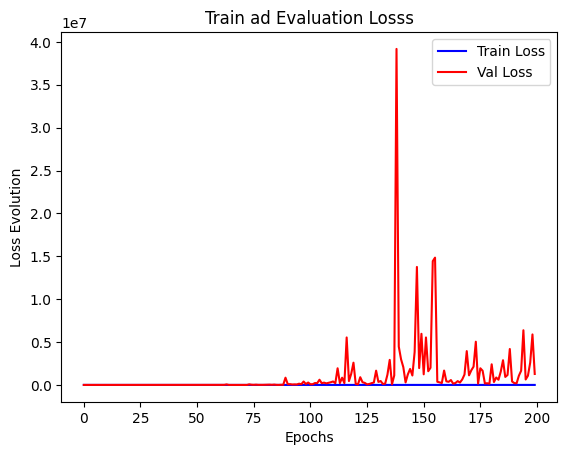

testing data:   0%|          | 0/21 [00:00<?, ?it/s]

MSE: tensor(55.5777, device='cuda:0')
RMSE: tensor(7.4550, device='cuda:0')
MAE: tensor(4.5957, device='cuda:0')
Spearman Corr: tensor(0.6836, device='cuda:0')


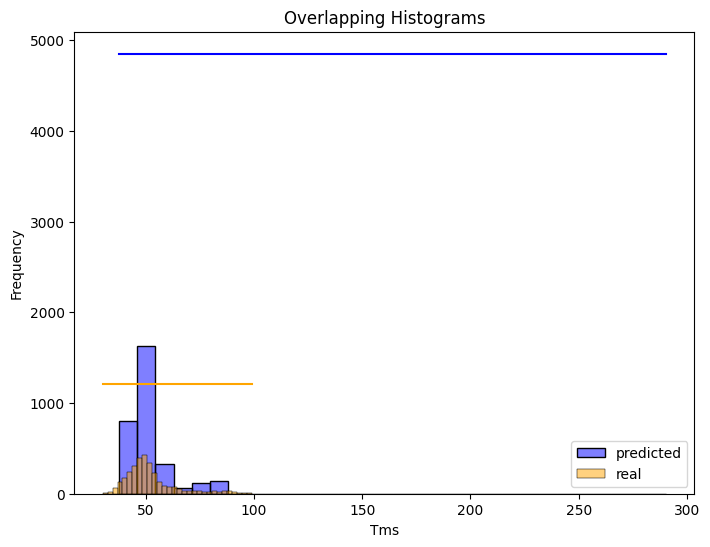

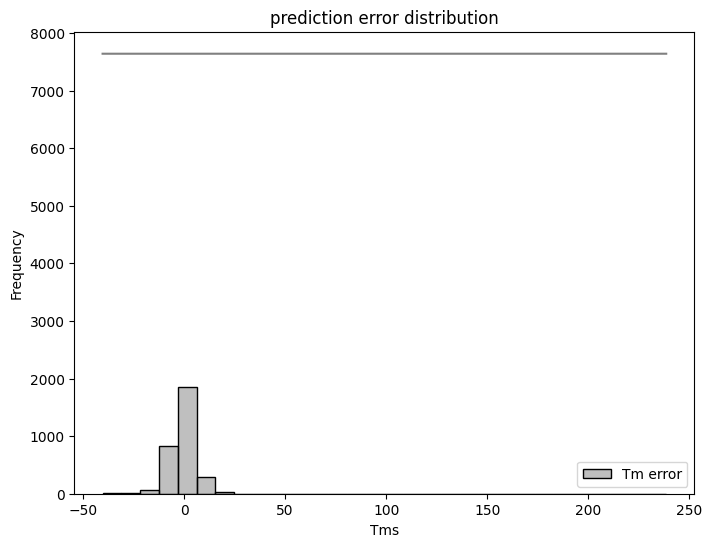

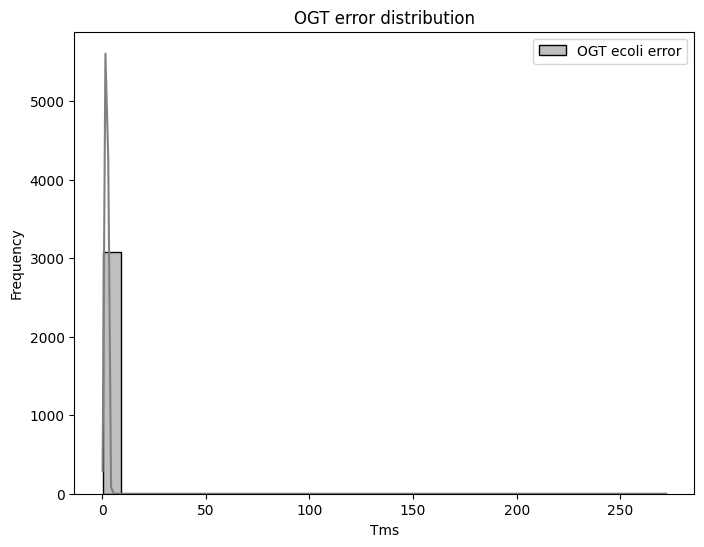

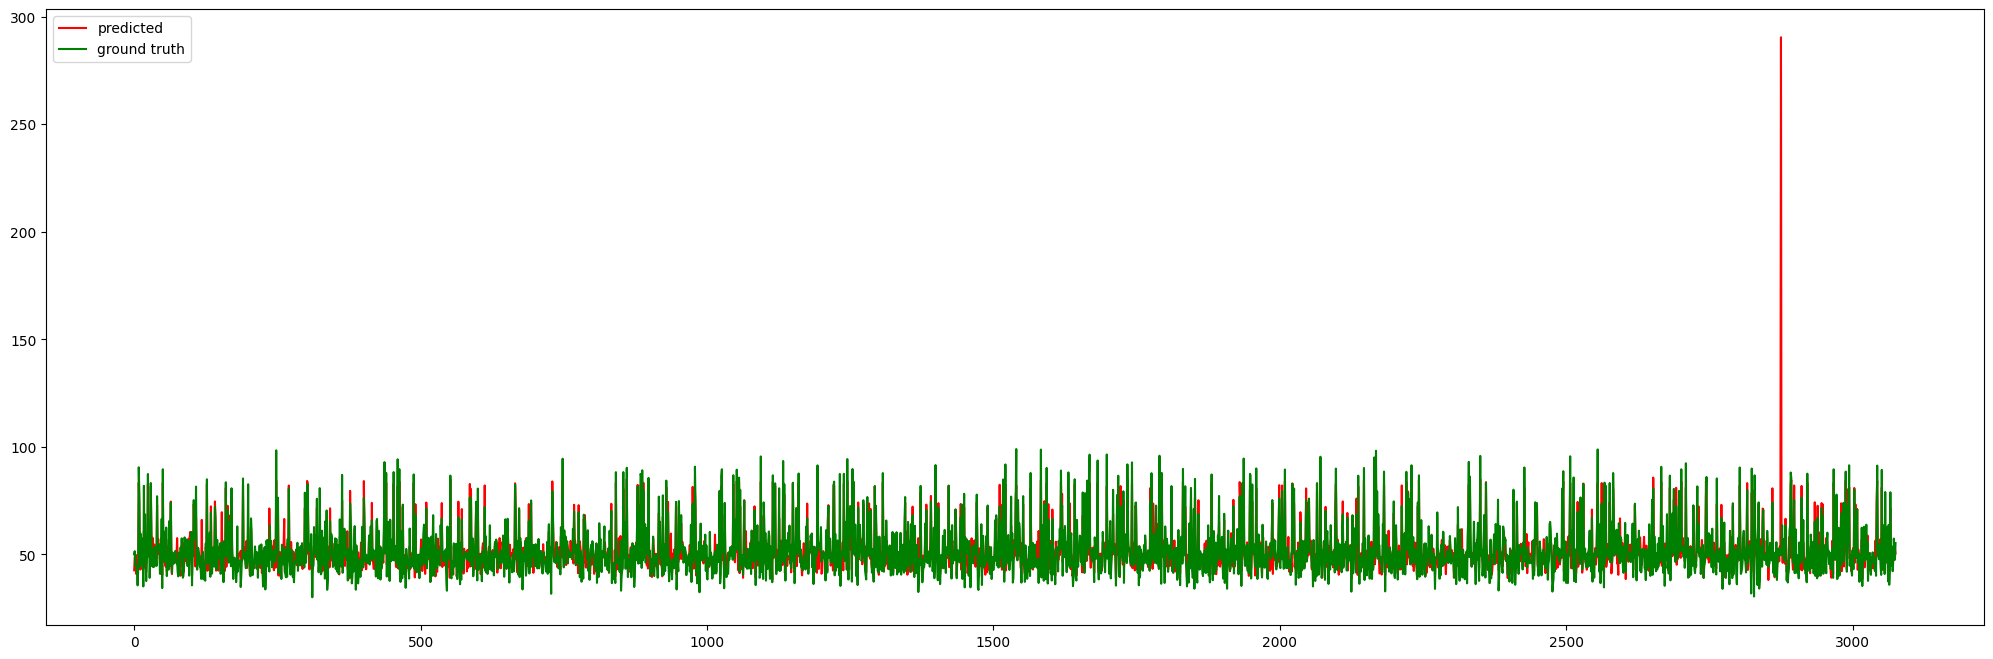

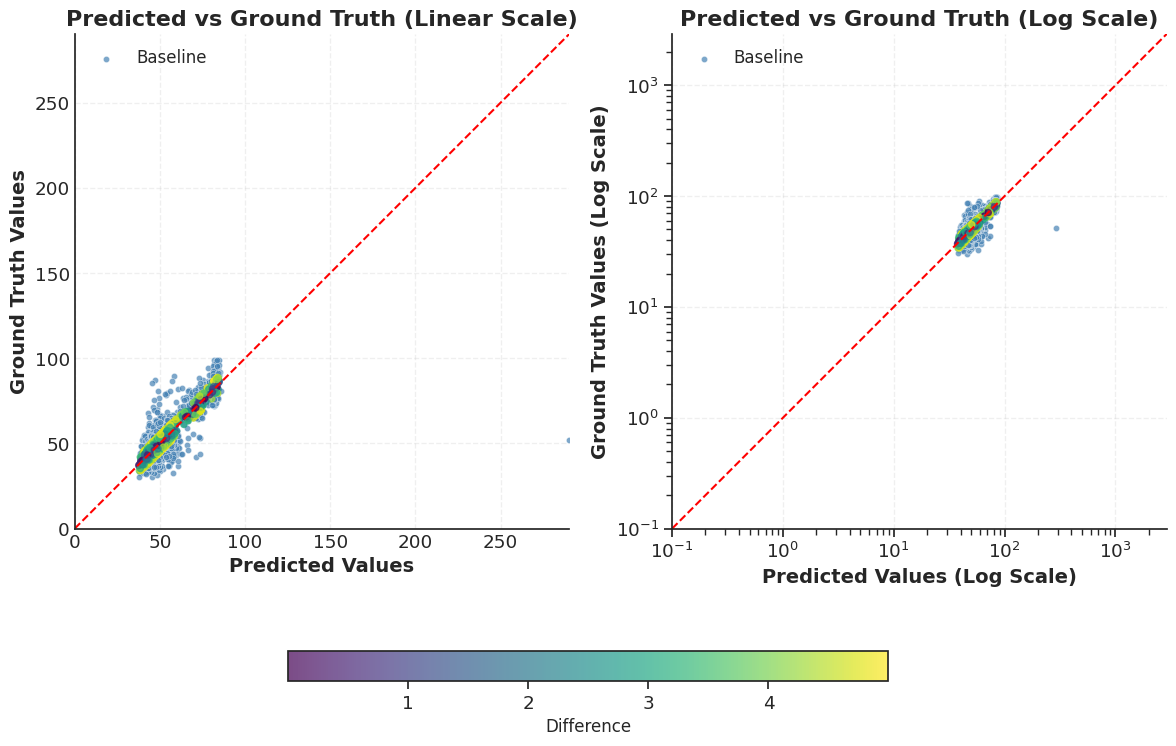

In [13]:

seq_struct_pred_W = LA_MLP_pred(embeddings_dim=1280, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)

optESM = torch.optim.AdamW(seq_struct_pred_W.parameters(), lr=1e-3)
lossESM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W, Trainer3, train_embedding_esm2, val_embedding_esm2, 
                              test_embedding_esm2, lossESM, optESM, epochs, device,
                              path_progres=path_progresESM, 
                              checkpoint_path=checkpoint_pathESM,
                              output_metrics=config['initial_paths']['output_metrics_ESM_only'])



### For Inverse Folding PiFold Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

Directory '../checkpoints/PiFold_only/Global/AllMeltome_composed_loss_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 1 loss: 1391.250 val loss: 121.939


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 2 loss: 114.633 val loss: 107.528


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 3 loss: 96.762 val loss: 100.805


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 4 loss: 88.960 val loss: 96.857


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 5 loss: 82.789 val loss: 88.277


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 6 loss: 76.138 val loss: 94.971


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 7 loss: 69.486 val loss: 83.257


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 8 loss: 63.919 val loss: 78.394


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 9 loss: 60.903 val loss: 85.067


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 10 loss: 56.943 val loss: 82.624


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 11 loss: 53.496 val loss: 79.642


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 12 loss: 50.835 val loss: 74.403


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 13 loss: 47.685 val loss: 68.610


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 14 loss: 46.869 val loss: 74.989


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 15 loss: 44.791 val loss: 70.194


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 16 loss: 42.264 val loss: 79.799


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 17 loss: 42.950 val loss: 75.802


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 18 loss: 41.240 val loss: 73.834


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 19 loss: 39.337 val loss: 73.797


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 20 loss: 39.346 val loss: 76.099


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 21 loss: 38.016 val loss: 70.811


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 22 loss: 59.475 val loss: 72.484


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 23 loss: 52.711 val loss: 69.764


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 24 loss: 47.246 val loss: 74.426


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 25 loss: 42.600 val loss: 69.196


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 26 loss: 41.598 val loss: 74.201


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 27 loss: 41.329 val loss: 79.130


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 28 loss: 40.694 val loss: 82.956


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 29 loss: 40.622 val loss: 69.525


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 30 loss: 37.389 val loss: 72.658


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 31 loss: 36.995 val loss: 70.006


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 32 loss: 36.198 val loss: 72.884


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 33 loss: 33.926 val loss: 67.510


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 34 loss: 33.072 val loss: 69.794


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 35 loss: 33.324 val loss: 68.397


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 36 loss: 32.104 val loss: 71.705


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 37 loss: 31.788 val loss: 83.929


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 38 loss: 31.311 val loss: 70.741


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 39 loss: 31.411 val loss: 68.817


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 40 loss: 30.786 val loss: 73.143


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 41 loss: 29.765 val loss: 73.005


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 42 loss: 29.959 val loss: 69.598


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 43 loss: 28.928 val loss: 74.841


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 44 loss: 28.939 val loss: 69.968


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 45 loss: 30.212 val loss: 71.623


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 46 loss: 29.345 val loss: 72.149


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 47 loss: 27.815 val loss: 76.811


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 48 loss: 27.958 val loss: 74.733


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 49 loss: 29.294 val loss: 75.397


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 50 loss: 28.272 val loss: 80.405


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 51 loss: 27.861 val loss: 69.810


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 52 loss: 26.480 val loss: 74.452


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 53 loss: 25.702 val loss: 70.135


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 54 loss: 25.713 val loss: 78.412


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 55 loss: 26.184 val loss: 68.068


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 56 loss: 25.399 val loss: 71.894


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 57 loss: 25.221 val loss: 73.104


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 58 loss: 24.647 val loss: 76.366


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 59 loss: 24.692 val loss: 73.677


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 60 loss: 23.218 val loss: 69.938


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 61 loss: 22.135 val loss: 74.624


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 62 loss: 23.779 val loss: 69.628


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 63 loss: 22.673 val loss: 71.291


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 64 loss: 21.963 val loss: 74.177


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 65 loss: 24.950 val loss: 89.112


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 66 loss: 24.053 val loss: 74.611


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 67 loss: 23.407 val loss: 92.879


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 68 loss: 24.638 val loss: 88.647


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 69 loss: 24.413 val loss: 89.970


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 70 loss: 24.227 val loss: 99.271


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 71 loss: 23.214 val loss: 69.507


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 72 loss: 22.042 val loss: 72.406


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 73 loss: 22.389 val loss: 74.744


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 74 loss: 21.790 val loss: 74.503


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 75 loss: 20.772 val loss: 71.755


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 76 loss: 21.667 val loss: 81.321


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 77 loss: 21.531 val loss: 82.019


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 78 loss: 20.845 val loss: 93.970


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 79 loss: 21.078 val loss: 72.870


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 80 loss: 22.137 val loss: 70.934


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 81 loss: 22.955 val loss: 69.061


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 82 loss: 21.758 val loss: 79.526


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 83 loss: 21.687 val loss: 71.637


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 84 loss: 19.846 val loss: 80.726


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 85 loss: 20.231 val loss: 76.191


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 86 loss: 19.992 val loss: 72.626


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 87 loss: 19.666 val loss: 85.018


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 88 loss: 20.486 val loss: 79.064


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 89 loss: 19.866 val loss: 80.329


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 90 loss: 19.484 val loss: 77.468


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 91 loss: 19.444 val loss: 77.752


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 92 loss: 19.592 val loss: 81.629


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 93 loss: 18.822 val loss: 73.469


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 94 loss: 19.011 val loss: 69.324


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 95 loss: 19.967 val loss: 69.302


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 96 loss: 19.741 val loss: 71.912


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 97 loss: 20.055 val loss: 74.495


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 98 loss: 18.294 val loss: 75.348


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 99 loss: 19.249 val loss: 69.558


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 100 loss: 18.546 val loss: 68.905


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 101 loss: 18.241 val loss: 75.733


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 102 loss: 18.436 val loss: 84.783


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 103 loss: 17.478 val loss: 72.816


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 104 loss: 18.176 val loss: 79.011


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 105 loss: 17.451 val loss: 71.876


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 106 loss: 18.547 val loss: 88.957


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 107 loss: 17.673 val loss: 68.685


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 108 loss: 17.939 val loss: 71.056


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 109 loss: 17.385 val loss: 76.838


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 110 loss: 17.673 val loss: 74.589


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 111 loss: 17.027 val loss: 74.317


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 112 loss: 17.662 val loss: 76.969


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 113 loss: 16.678 val loss: 73.480


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 114 loss: 16.653 val loss: 74.655


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 115 loss: 16.653 val loss: 82.900


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 116 loss: 16.710 val loss: 71.687


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 117 loss: 15.684 val loss: 80.918


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 118 loss: 16.759 val loss: 70.278


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 119 loss: 16.085 val loss: 69.774


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 120 loss: 15.682 val loss: 78.478


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 121 loss: 16.184 val loss: 83.304


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 122 loss: 15.293 val loss: 71.496


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 123 loss: 17.039 val loss: 74.574


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 124 loss: 15.308 val loss: 75.506


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 125 loss: 15.274 val loss: 76.683


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 126 loss: 15.873 val loss: 75.796


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 127 loss: 15.404 val loss: 79.143


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 128 loss: 15.315 val loss: 81.223


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 129 loss: 15.502 val loss: 75.178


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 130 loss: 15.926 val loss: 81.438


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 131 loss: 16.023 val loss: 81.053


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 132 loss: 15.646 val loss: 86.181


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 133 loss: 15.055 val loss: 75.440


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 134 loss: 15.496 val loss: 82.024


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 135 loss: 15.415 val loss: 80.162


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 136 loss: 14.679 val loss: 72.943


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 137 loss: 15.122 val loss: 79.674


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 138 loss: 14.329 val loss: 70.460


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 139 loss: 15.144 val loss: 77.294


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 140 loss: 14.226 val loss: 87.647


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 141 loss: 14.534 val loss: 77.687


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 142 loss: 14.848 val loss: 91.347


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 143 loss: 14.526 val loss: 79.668


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 144 loss: 14.083 val loss: 77.618


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 145 loss: 14.102 val loss: 81.255


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 146 loss: 14.519 val loss: 74.772


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 147 loss: 13.983 val loss: 74.890


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 148 loss: 14.538 val loss: 70.842


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 149 loss: 13.044 val loss: 70.527


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 150 loss: 14.417 val loss: 90.171


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 151 loss: 13.626 val loss: 70.421


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 152 loss: 14.099 val loss: 76.007


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 153 loss: 14.171 val loss: 69.958


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 154 loss: 13.800 val loss: 71.186


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 155 loss: 14.081 val loss: 73.558


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 156 loss: 13.889 val loss: 74.409


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 157 loss: 14.002 val loss: 73.726


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 158 loss: 14.038 val loss: 85.283


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 159 loss: 13.602 val loss: 70.226


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 160 loss: 13.858 val loss: 71.297


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 161 loss: 12.904 val loss: 69.327


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 162 loss: 13.492 val loss: 82.565


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 163 loss: 12.859 val loss: 77.545


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 164 loss: 13.196 val loss: 71.698


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 165 loss: 13.108 val loss: 76.537


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 166 loss: 12.268 val loss: 73.132


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 167 loss: 12.508 val loss: 69.637


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 168 loss: 12.723 val loss: 75.322


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 169 loss: 12.616 val loss: 79.946


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 170 loss: 12.861 val loss: 69.369


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 171 loss: 13.077 val loss: 71.753


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 172 loss: 13.384 val loss: 71.113


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 173 loss: 13.129 val loss: 79.054


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 174 loss: 12.813 val loss: 73.509


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 175 loss: 12.807 val loss: 67.530


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 176 loss: 12.811 val loss: 67.425


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 177 loss: 13.836 val loss: 72.360


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 178 loss: 13.291 val loss: 70.661


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 179 loss: 13.233 val loss: 71.625


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 180 loss: 12.518 val loss: 71.603


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 181 loss: 12.857 val loss: 72.937


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 182 loss: 11.858 val loss: 72.588


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 183 loss: 12.382 val loss: 77.324


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 184 loss: 11.808 val loss: 70.553


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 185 loss: 11.839 val loss: 69.960


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 186 loss: 13.015 val loss: 72.200


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 187 loss: 13.027 val loss: 75.773


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 188 loss: 11.963 val loss: 73.590


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 189 loss: 11.918 val loss: 81.055


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 190 loss: 12.771 val loss: 72.275


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 191 loss: 12.847 val loss: 73.691


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 192 loss: 12.466 val loss: 71.723


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 193 loss: 13.120 val loss: 77.394


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 194 loss: 12.614 val loss: 73.147


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 195 loss: 13.441 val loss: 72.650


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 196 loss: 12.955 val loss: 72.421


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 197 loss: 12.356 val loss: 74.061


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 198 loss: 11.716 val loss: 76.965


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 199 loss: 12.482 val loss: 86.290


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 200 loss: 11.692 val loss: 71.504


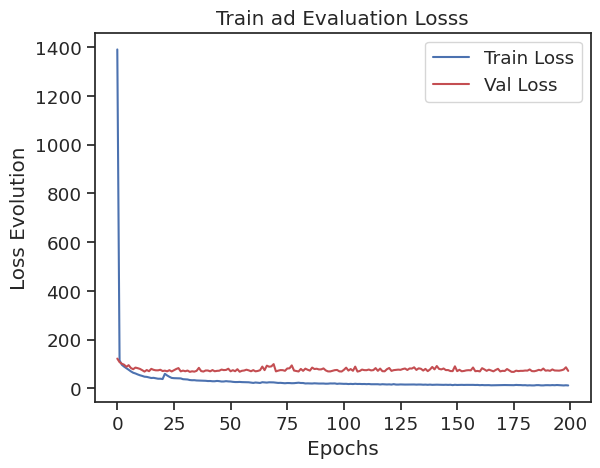

testing data:   0%|          | 0/21 [00:00<?, ?it/s]

MSE: tensor(89.1427, device='cuda:0')
RMSE: tensor(9.4415, device='cuda:0')
MAE: tensor(6.7923, device='cuda:0')
Spearman Corr: tensor(0.3876, device='cuda:0')


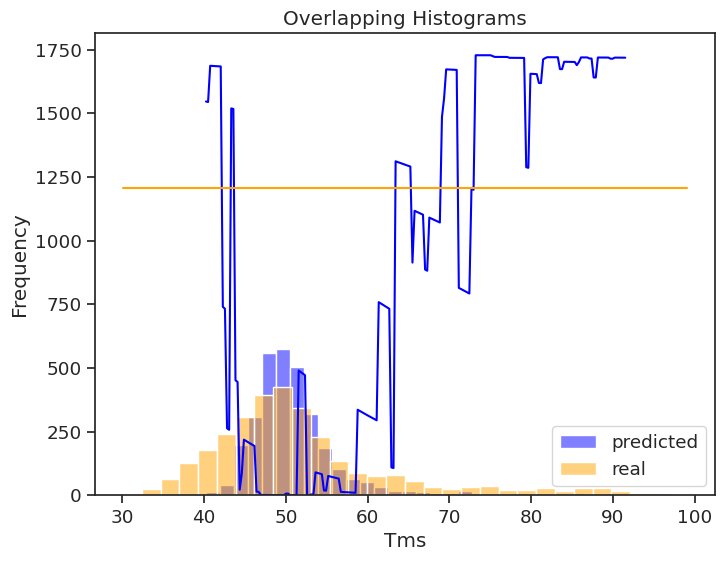

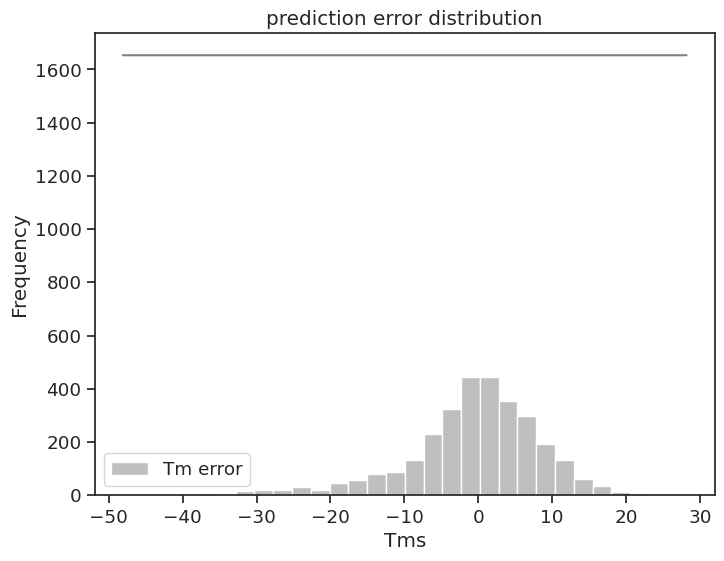

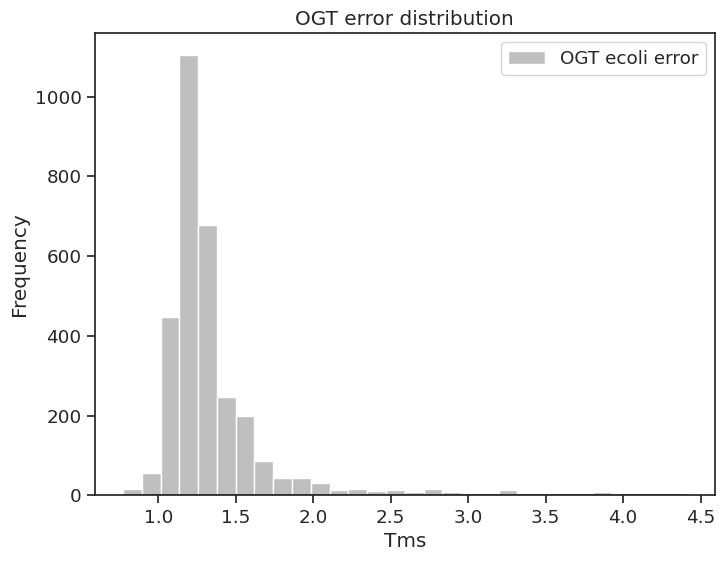

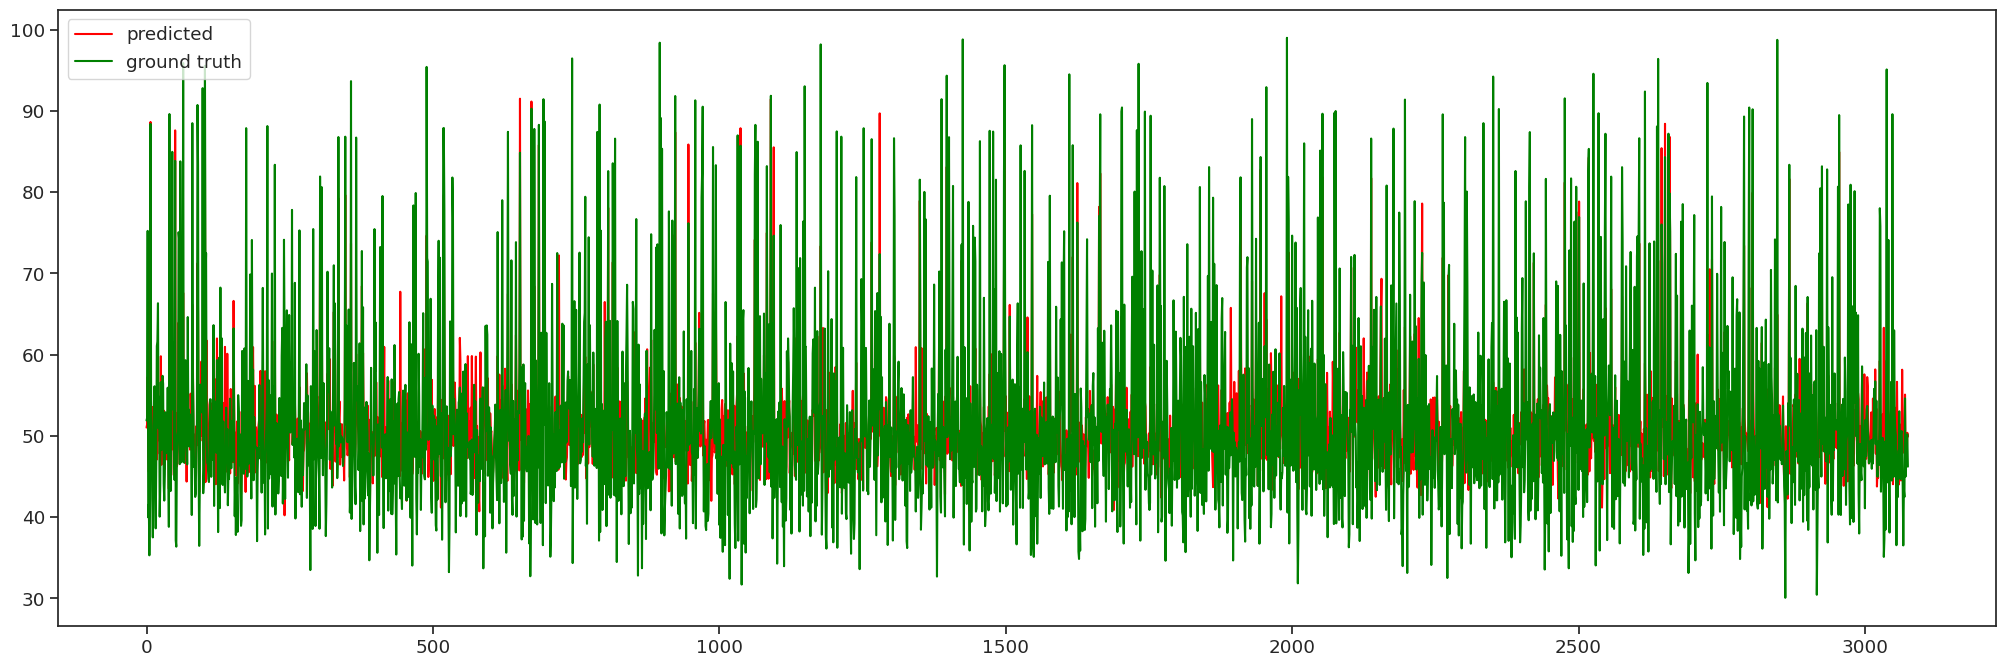

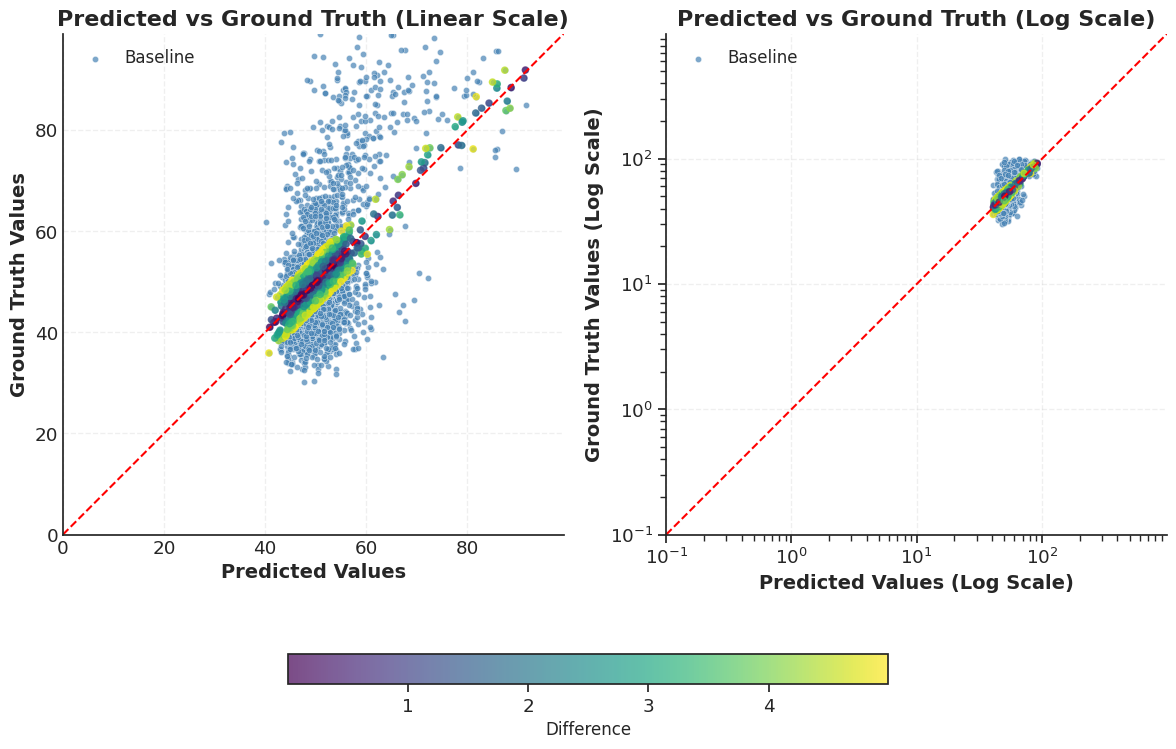

In [14]:

seq_struct_pred_W_PiFold = LA_MLP_pred(embeddings_dim=128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optPiFold = torch.optim.AdamW(seq_struct_pred_W_PiFold.parameters(), lr=1e-3)
lossPiFold= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W_PiFold, Trainer3, train_embedding_PiFold, val_embedding_PiFold, 
                              test_embedding_PiFold, lossPiFold, optPiFold, epochs, device,
                              path_progres=path_progresPiFold, 
                              checkpoint_path=checkpoint_pathPiFold,
                              output_metrics=config['initial_paths']['output_metrics_PiFold_only'])


### For Both ESM2 and Inverse Folding PiFold Contributions Together Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

In [15]:

import torchsort, sys
sys.path.append(os.path.abspath("../ref_models/fast_soft_sort"))
from ref_models.fast_soft_sort.fast_soft_sort.pytorch_ops import soft_rank, soft_sort

#import ipdb; ipdb.set_trace()
seq_struct_pred_W_merged = LA_MLP_pred(embeddings_dim=1280+128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optIFM = torch.optim.AdamW(seq_struct_pred_W_merged.parameters(), lr=1e-3)
lossIFM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W_merged, Trainer3, train_embedding_merged, val_embedding_merged, 
                              test_embedding_merged, lossIFM, optIFM, epochs, device,
                              path_progres=path_progresMix, 
                              checkpoint_path=checkpoint_pathMix,
                              output_metrics=config['initial_paths']['output_metrics_Both'])


Directory '../checkpoints/Mix/Global/AllMeltome_composed_loss_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 1 loss: 1374.625 val loss: 792.838


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 2 loss: 85.566 val loss: 60.431


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 3 loss: 56.468 val loss: 40.370


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 4 loss: 39.791 val loss: 39.040


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 5 loss: 32.119 val loss: 36.100


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 6 loss: 27.554 val loss: 42.422


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 7 loss: 23.849 val loss: 42.396


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 8 loss: 20.733 val loss: 38.395


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 9 loss: 19.438 val loss: 40.339


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 10 loss: 18.289 val loss: 36.900


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 11 loss: 21.372 val loss: 38.483


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 12 loss: 25.693 val loss: 41.683


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 13 loss: 20.787 val loss: 43.190


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 14 loss: 20.165 val loss: 38.180


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 15 loss: 16.913 val loss: 40.111


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 16 loss: 17.158 val loss: 44.674


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 17 loss: 16.238 val loss: 39.880


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 18 loss: 15.118 val loss: 38.285


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 19 loss: 15.178 val loss: 37.721


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 20 loss: 14.282 val loss: 38.233


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 21 loss: 13.550 val loss: 39.506


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 22 loss: 14.618 val loss: 39.299


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 23 loss: 13.405 val loss: 39.540


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 24 loss: 13.718 val loss: 38.981


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 25 loss: 13.243 val loss: 41.574


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 26 loss: 13.618 val loss: 38.910


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 27 loss: 12.492 val loss: 38.749


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 28 loss: 12.996 val loss: 38.698


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 29 loss: 11.756 val loss: 38.099


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 30 loss: 12.925 val loss: 42.098


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 31 loss: 12.059 val loss: 37.576


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 32 loss: 11.267 val loss: 37.688


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 33 loss: 11.928 val loss: 39.162


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 34 loss: 11.728 val loss: 58.167


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 35 loss: 11.068 val loss: 42.153


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 36 loss: 10.608 val loss: 122.175


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 37 loss: 10.548 val loss: 800.564


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 38 loss: 10.690 val loss: 43.900


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 39 loss: 10.680 val loss: 40.559


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 40 loss: 11.362 val loss: 40.981


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 41 loss: 10.558 val loss: 40.706


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 42 loss: 10.221 val loss: 44.124


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 43 loss: 10.268 val loss: 40.215


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 44 loss: 9.614 val loss: 44.021


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 45 loss: 9.539 val loss: 42.038


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 46 loss: 9.289 val loss: 47.937


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 47 loss: 9.703 val loss: 50.208


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 48 loss: 9.654 val loss: 39.715


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 49 loss: 9.881 val loss: 49.728


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 50 loss: 9.107 val loss: 41.019


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 51 loss: 9.624 val loss: 46.993


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 52 loss: 9.159 val loss: 42.600


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 53 loss: 9.287 val loss: 38.514


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 54 loss: 7.969 val loss: 43.996


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 55 loss: 9.210 val loss: 40.326


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 56 loss: 8.394 val loss: 46.652


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 57 loss: 9.065 val loss: 43.579


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 58 loss: 7.981 val loss: 45.174


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 59 loss: 9.158 val loss: 39.517


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 60 loss: 8.614 val loss: 39.882


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 61 loss: 8.507 val loss: 45.109


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 62 loss: 8.786 val loss: 42.759


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 63 loss: 7.788 val loss: 46.187


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 64 loss: 8.098 val loss: 41.824


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 65 loss: 8.417 val loss: 45.603


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 66 loss: 8.671 val loss: 44.790


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 67 loss: 8.412 val loss: 43.482


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 68 loss: 8.401 val loss: 51.359


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 69 loss: 8.808 val loss: 47.685


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 70 loss: 8.333 val loss: 50.498


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 71 loss: 7.711 val loss: 44.953


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 72 loss: 8.142 val loss: 45.038


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 73 loss: 8.296 val loss: 50.434


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 74 loss: 8.289 val loss: 42.927


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 75 loss: 7.060 val loss: 43.327


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 76 loss: 8.042 val loss: 47.000


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 77 loss: 8.287 val loss: 40.726


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 78 loss: 7.475 val loss: 39.477


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 79 loss: 8.370 val loss: 42.855


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 80 loss: 6.878 val loss: 44.793


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 81 loss: 6.712 val loss: 51.189


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 82 loss: 6.940 val loss: 44.390


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 83 loss: 7.516 val loss: 47.800


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 84 loss: 7.459 val loss: 60.162


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 85 loss: 6.778 val loss: 43.091


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 86 loss: 7.279 val loss: 47.066


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 87 loss: 7.138 val loss: 55.071


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 88 loss: 7.639 val loss: 49.542


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 89 loss: 7.755 val loss: 44.435


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 90 loss: 7.561 val loss: 43.807


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 91 loss: 7.766 val loss: 56.545


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 92 loss: 7.468 val loss: 47.579


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 93 loss: 6.437 val loss: 43.096


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 94 loss: 7.040 val loss: 61.720


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 95 loss: 6.785 val loss: 44.873


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 96 loss: 6.965 val loss: 46.520


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 97 loss: 6.887 val loss: 49.932


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 98 loss: 7.143 val loss: 50.719


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 99 loss: 6.930 val loss: 52.554


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 100 loss: 6.756 val loss: 53.280


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 101 loss: 6.705 val loss: 50.190


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 102 loss: 6.622 val loss: 72.392


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 103 loss: 7.031 val loss: 56.946


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 104 loss: 6.047 val loss: 50.715


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 105 loss: 7.785 val loss: 52.801


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 106 loss: 6.897 val loss: 47.220


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 107 loss: 6.946 val loss: 51.928


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 108 loss: 6.285 val loss: 59.732


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 109 loss: 6.009 val loss: 53.387


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 110 loss: 6.469 val loss: 53.700


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 111 loss: 6.719 val loss: 51.025


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 112 loss: 6.286 val loss: 5663.523


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 113 loss: 6.657 val loss: 49.441


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 114 loss: 6.271 val loss: 55.579


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 115 loss: 6.106 val loss: 56.309


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 116 loss: 6.598 val loss: 57.298


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 117 loss: 6.206 val loss: 56.533


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 118 loss: 6.275 val loss: 59.227


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 119 loss: 6.869 val loss: 57.402


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 120 loss: 6.442 val loss: 62.387


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 121 loss: 6.446 val loss: 5151.436


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 122 loss: 5.885 val loss: 127.393


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 123 loss: 6.170 val loss: 3629.861


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 124 loss: 6.021 val loss: 55.506


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]

epoch: 125 loss: 6.167 val loss: 64.043


training epoch by batches:   0%|          | 0/147 [00:00<?, ?it/s]